In [128]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import pandas as pd

In [129]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
# sources = ["prefab4"]
sources = os.listdir(data_dir)
feat_dfs = []
label_dfs = []
for source in sources:
    # if source == "treebase_v1":
    #     continue
    feat_df = pd.read_parquet(data_dir / source / "features.parquet")
    label_df = pd.read_parquet(data_dir / source / "stats.parquet")
    label_df = label_df[["mean"]].query("method == 'dpos'").droplevel(2)
    feat_dfs.append(feat_df)
    label_dfs.append(label_df)

label_df = pd.concat(label_dfs, axis=0).sort_index()
feat_df = pd.concat(feat_dfs, axis=0).sort_index()

is_dna = feat_df.is_dna
feat_df = feat_df.drop("is_dna", axis=1)
feat_df = feat_df.loc[:, ~feat_df.columns.str.endswith("monte-carlo-pi")]

assert (feat_df.index == label_df.index).all()

In [130]:
sample = np.random.randint(0, len(label_df), int(len(label_df) * 0.7))
train_idxs = label_df.iloc[sample].index
test_idxs = feat_df.drop(feat_df.iloc[sample].index).index

In [131]:
feat_df.isna().sum().sort_values(ascending=False)[:5]

num_seqs           0
min:seq_length     0
max:seq_length     0
mean:seq_length    0
std:seq_length     0
dtype: int64

In [162]:
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

# selector = SequentialFeatureSelector(
#     LinearRegression(), n_features_to_select=30
# )
# model = RandomForestRegressor(n_estimators=20)
model = HistGradientBoostingRegressor(
    max_features=0.1,
    max_depth=7,
    learning_rate=0.05,
    max_leaf_nodes=None,
    max_iter=1000,
    # loss="absolute_error",
)
# pipeline = Pipeline([("select", selector), ("model", model)])
pipeline = Pipeline([("model", model)])
# model = GradientBoostingRegressor()
# model = LinearRegression()
pipeline.fit(feat_df.loc[train_idxs], label_df.loc[train_idxs].to_numpy().ravel())
y_pred = pipeline.predict(feat_df.loc[test_idxs])

In [163]:
y_true = label_df.loc[test_idxs].to_numpy().ravel()
rmse = (((y_pred - y_true) ** 2).sum() / len(y_true)) ** 0.5
corr = np.corrcoef(y_true, y_pred)[0, 1]
print(f"[RMSE] {rmse:.4f}")
print(f"[CORR] {corr:.4f}")

[RMSE] 0.0891
[CORR] 0.8520


Text(0, 0.5, 'Label')

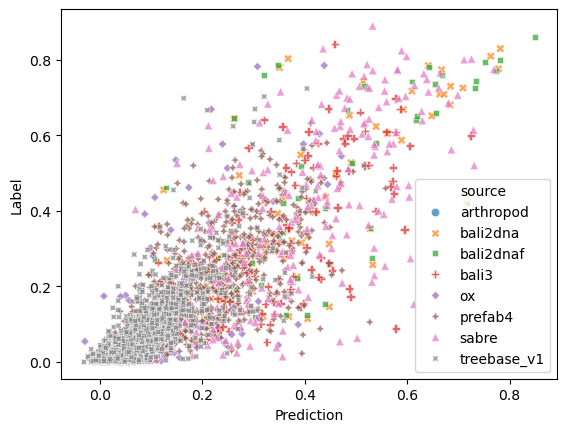

In [164]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[test_idxs].reset_index().loc[:, "source"]
sn.scatterplot(x=y_pred, y=y_true, alpha=0.7, style=sources, hue=sources)
plt.xlabel("Prediction")
plt.ylabel("Label")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )